In [1]:
! pip install torchmetrics

In [2]:
import sys

# remove any partially-imported torch submodules
for k in list(sys.modules.keys()):
    if k == "torch" or k.startswith("torch."):
        del sys.modules[k]

import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.6.0+cu124
cuda available: True


In [3]:
from __future__ import annotations

import os
import sys
import json
import time
import math
import urllib.request
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [4]:
# =============================================================================
# 0) SMALL UTILS
# =============================================================================

def show_quickstart() -> None:
    print(r"""
╔═══════════════════════════════════════════════════════════════╗
║              DINOv3 Depth Utilities (Notebook-safe)           ║
╚═══════════════════════════════════════════════════════════════╝

Typical Notebook Flow:

1) Download + prepare NYU labeled set
   download_nyu_depth_v2("data/nyu_depth_v2")

2) Quick sanity test (dummy tensors)
   quick_test(repo_or_dir="dinov3", model_name="dinov3_vitb16", weights_path="dinov3_vitb16.pth")

""")

def _download_with_progress(url: str, out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)

    def reporthook(blocknum, blocksize, totalsize):
        if totalsize <= 0:
            return
        downloaded = blocknum * blocksize
        pct = min(100.0, downloaded * 100.0 / totalsize)
        print(f"\rDownloading... {pct:6.2f}% ({downloaded/1e9:.2f}/{totalsize/1e9:.2f} GB)", end="")

    tmp_path = out_path.with_suffix(out_path.suffix + ".part")
    print(f"URL: {url}")
    print(f"OUT: {out_path}")
    urllib.request.urlretrieve(url, tmp_path, reporthook=reporthook)
    print("\n✓ Download complete")
    tmp_path.rename(out_path)

In [5]:
# =============================================================================
# 1) NYU DEPTH V2: DOWNLOAD + ORGANIZE (STREAMING)
# =============================================================================

def download_nyu_depth_v2(output_dir: str = "data/nyu_depth_v2") -> None:
    """
    Download NYU Depth V2 labeled .mat and organize into:
      output_dir/train/rgb, output_dir/train/depth
      output_dir/val/rgb,   output_dir/val/depth
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    print("=" * 70)
    print("NYU Depth V2 (labeled) Setup")
    print("=" * 70)

    labeled_url = "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"
    labeled_path = output_dir / "nyu_depth_v2_labeled.mat"

    if not labeled_path.exists():
        print("\n[1/2] Downloading labeled dataset (~2.8 GB)...")
        _download_with_progress(labeled_url, labeled_path)
    else:
        print("\n[1/2] Labeled dataset already exists")

    print("\n[2/2] Extracting + organizing (streaming from HDF5)...")
    organize_nyu_dataset(mat_file=labeled_path, output_dir=output_dir)

    print("\n" + "=" * 70)
    print("Dataset ready!")
    print(f"Location: {output_dir}")
    print("=" * 70)


def organize_nyu_dataset(mat_file: Path, output_dir: Path, train_ratio: float = 0.8) -> None:
    """
    Stream-extract the .mat HDF5 structure without loading everything into RAM.
    Saves:
      - RGB as PNG (8-bit)
      - Depth as PNG (16-bit), normalized per image (quick training; not metric)
    """
    output_dir = Path(output_dir)
    MAX_DEPTH = 10.0  # meters (common choice for NYU)


    for split in ["train", "val"]:
        (output_dir / split / "rgb").mkdir(parents=True, exist_ok=True)
        (output_dir / split / "depth").mkdir(parents=True, exist_ok=True)

    with h5py.File(mat_file, "r") as f:
        # Common keys: 'images', 'depths'
        if "images" not in f or "depths" not in f:
            raise KeyError(f"Expected datasets 'images' and 'depths' in {mat_file}. Found: {list(f.keys())}")

        images_ds = f["images"]
        depths_ds = f["depths"]

        # Handle typical NYU labeled shapes:
        # images: (3, H, W, N) or (N, H, W, 3)
        # depths: (H, W, N) or (N, H, W)
        # We infer N robustly.
        if images_ds.ndim == 4 and images_ds.shape[0] == 3:
            n_samples = images_ds.shape[-1]
        elif images_ds.ndim == 4 and images_ds.shape[-1] == 3:
            n_samples = images_ds.shape[0]
        else:
            raise ValueError(f"Unexpected images shape: {images_ds.shape}")

        n_train = int(train_ratio * n_samples)
        print(f"Images dataset shape: {images_ds.shape}")
        print(f"Depths dataset shape: {depths_ds.shape}")
        print(f"Total samples: {n_samples} | Train: {n_train} | Val: {n_samples - n_train}")

        for idx in tqdm(range(n_samples), desc="Extracting"):
            split = "train" if idx < n_train else "val"

            # ---- RGB ----
            if images_ds.shape[0] == 3:
                # (3, H, W, N) -> (H, W, 3)
                rgb = np.array(images_ds[:, :, :, idx], dtype=np.uint8)
                rgb = np.transpose(rgb, (1, 2, 0))
            else:
                # (N, H, W, 3)
                rgb = np.array(images_ds[idx], dtype=np.uint8)

            rgb_img = Image.fromarray(rgb, mode="RGB")
            rgb_img.save(output_dir / split / "rgb" / f"{idx:05d}.png")

            # ---- DEPTH (global scale; metric-ish) ----
            depth = np.clip(depth, 0.0, MAX_DEPTH)            # keep within [0, MAX_DEPTH]
            depth_u16 = (depth / MAX_DEPTH * 65535.0).astype(np.uint16)
            depth_img = Image.fromarray(depth_u16, mode="I;16")
            depth_img.save(output_dir / split / "depth" / f"{idx:05d}.png")

    print("✓ Dataset organized")


In [6]:
# =============================================================================
# 2) DATASET LOADER
# =============================================================================

class NYUDepthV2Dataset(Dataset):
    """
    Reads the organized PNG structure:
      root/split/rgb/*.png (8-bit)
      root/split/depth/*.png (16-bit)
    """
    def __init__(self, root_dir: str, split: str = "train", img_size: int = 512):
        self.root_dir = Path(root_dir)
        self.split = split
        self.img_size = img_size

        self.rgb_files = sorted((self.root_dir / split / "rgb").glob("*.png"))
        self.depth_files = sorted((self.root_dir / split / "depth").glob("*.png"))

        if len(self.rgb_files) == 0:
            raise FileNotFoundError(f"No RGB files found in {self.root_dir / split / 'rgb'}")
        if len(self.rgb_files) != len(self.depth_files):
            raise RuntimeError(f"RGB/Depth count mismatch: {len(self.rgb_files)} vs {len(self.depth_files)}")

        self.rgb_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        '''# Depth: load 16-bit -> float32 in [0,1] (since we saved per-image normalized)
        self.depth_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),  # PIL 16-bit => tensor float in [0,1] (scaled)
        ])'''

    def __len__(self) -> int:
        return len(self.rgb_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        rgb_img   = Image.open(self.rgb_files[idx]).convert("RGB")
        depth_img = Image.open(self.depth_files[idx])  # 16-bit PNG (I;16)
    
        # RGB (same as before)
        rgb_t = self.rgb_transform(rgb_img)
    
        # Depth: explicit 16-bit -> float32 [0,1]
        depth_np = np.array(depth_img, dtype=np.float32) / 65535.0      # [H,W] in [0,1]
        depth_t  = torch.from_numpy(depth_np).unsqueeze(0)              # [1,H,W]
    
        # Resize depth to match rgb size (use nearest to avoid smoothing)
        depth_t = F.interpolate(
            depth_t.unsqueeze(0),                                       # [1,1,H,W]
            size=(self.img_size, self.img_size),
            mode="nearest"
        ).squeeze(0)                                                    # [1,H,W]
    
        # Avoid exact zeros for log stability
        depth_t = depth_t.clamp_min(1e-6)
    
        return rgb_t, depth_t


In [7]:
class DINOv3Encoder(nn.Module):
    """
    Loads DINOv3 from a local hub directory WITHOUT downloading.
    Requires weights_path.
    """
    def __init__(
        self,
        repo_or_dir: str = "dinov3",
        model_name: str = "dinov3_vitb16",
        frozen: bool = True,
        weights_path: Optional[str] = None,
    ):
        super().__init__()

        if weights_path is None:
            raise ValueError(
                "weights_path is None. Provide your local checkpoint path (to avoid 403 downloads)."
            )

        weights_path = os.path.abspath(weights_path)
        if not os.path.isfile(weights_path):
            raise FileNotFoundError(f"weights_path not found: {weights_path}")

        print("[DINOv3Encoder] torch.hub.load(source='local') (no download)")
        print("  repo_or_dir =", repo_or_dir)
        print("  model_name  =", model_name)
        print("  weights     =", weights_path)

        hub_kwargs = dict(source="local")

        # 1) Load architecture WITHOUT pretrained download
        # Many hubconfs support pretrained=False; try it first.
        try:
            self.encoder = torch.hub.load(repo_or_dir, model_name, pretrained=False, **hub_kwargs)
        except TypeError:
            # fallback: load raw model object (some repos ignore pretrained flag)
            self.encoder = torch.hub.load(repo_or_dir, model_name, **hub_kwargs)

        # 2) Load checkpoint explicitly (avoid hub trying URLs)
        ckpt = torch.load(weights_path, map_location="cpu")
        if isinstance(ckpt, dict) and "state_dict" in ckpt:
            ckpt = ckpt["state_dict"]

        missing, unexpected = self.encoder.load_state_dict(ckpt, strict=False)
        print("[DINOv3Encoder] Local weights loaded ✅")
        if missing:
            print("  missing keys:", len(missing))
        if unexpected:
            print("  unexpected keys:", len(unexpected))

        if frozen:
            for p in self.encoder.parameters():
                p.requires_grad = False
            print("[DINOv3Encoder] Encoder frozen ✅")

        self.embed_dim = getattr(self.encoder, "embed_dim", None) or getattr(self.encoder, "dim", None)
        if self.embed_dim is None:
            raise AttributeError("Could not infer embed_dim from encoder object.")

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        if not hasattr(self.encoder, "get_intermediate_layers"):
            raise AttributeError("Encoder has no get_intermediate_layers().")
        feats =  self.encoder.get_intermediate_layers(x, n=4)
        return feats


In [8]:
# =============================================================================
# 4) DEPTH DECODER (DPT-STYLE LIGHT) 
# =============================================================================

class DepthDecoder(nn.Module):
    def __init__(self, encoder_dim: int = 768, decoder_features: int = 256):
        super().__init__()

        # ---- small helper blocks (kept inside to avoid renaming other classes) ----
        def conv_gn_act(in_c, out_c, k=3, p=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, k, padding=p, bias=False),
                nn.GroupNorm(num_groups=min(8, out_c), num_channels=out_c),
                nn.GELU(),
            )

        class ResRefine(nn.Module):
            def __init__(self, ch):
                super().__init__()
                self.a = conv_gn_act(ch, ch, 3, 1)
                self.b = conv_gn_act(ch, ch, 3, 1)
            def forward(self, x):
                return x + self.b(self.a(x))

        class FusionBlock(nn.Module):
            """
            Upsample + CONCAT skip + 1x1 reduce + refine.
            Concat tends to work better than add for depth heads.
            """
            def __init__(self, ch):
                super().__init__()
                self.reduce = conv_gn_act(ch * 2, ch, k=1, p=0)
                self.refine = ResRefine(ch)
            def forward(self, x, skip):
                if x.shape[-2:] != skip.shape[-2:]:
                    x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
                x = torch.cat([x, skip], dim=1)
                x = self.reduce(x)
                x = self.refine(x)
                return x

        # ---- 1) project each ViT feature to decoder_features ----
        self.projections = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dim, decoder_features, 1, bias=False),
                nn.GroupNorm(num_groups=min(8, decoder_features), num_channels=decoder_features),
                nn.GELU(),
            )
            for _ in range(4)
        ])

        # refine each level a bit
        self.ref0 = ResRefine(decoder_features)
        self.ref1 = ResRefine(decoder_features)
        self.ref2 = ResRefine(decoder_features)
        self.ref3 = ResRefine(decoder_features)

        # ---- 2) top-down fusion blocks ----
        self.fuse32 = FusionBlock(decoder_features)
        self.fuse21 = FusionBlock(decoder_features)
        self.fuse10 = FusionBlock(decoder_features)

        # ---- 3) final head (raw logits; keep NO ReLU at end) ----
        self.depth_head = nn.Sequential(
            conv_gn_act(decoder_features, decoder_features // 2, 3, 1),
            conv_gn_act(decoder_features // 2, 64, 3, 1),
            nn.Conv2d(64, 1, 1),
        )

    @staticmethod
    def _tokens_to_map(feat: torch.Tensor) -> torch.Tensor:
        """
        [B, N, C] -> [B, C, H, W]
        Handles CLS token if present (N = 1 + H*W).
        """
        B, N, C = feat.shape

        # if N-1 is a perfect square, assume CLS is present and remove it
        s = int(math.sqrt(max(0, N - 1)))
        if s * s == (N - 1):
            feat = feat[:, 1:, :]
            N = N - 1

        H = W = int(math.sqrt(N))
        if H * W != N:
            raise ValueError(f"Patch tokens N={N} not square after CLS handling. feat shape={feat.shape}")

        return feat.transpose(1, 2).reshape(B, C, H, W).contiguous()

    def forward(self, features: List[torch.Tensor], target_size: Tuple[int, int]) -> torch.Tensor:
        """
        features: list of 4 tensors [B, N, C]
        returns: raw depth logits [B,1,H,W]
        """
        feats_2d = []
        for i, feat in enumerate(features):
            x = self._tokens_to_map(feat)     # [B,C,H,W]
            x = self.projections[i](x)        # [B,decoder_features,H,W]
            feats_2d.append(x)

        # keep your convention: feats_2d[3] deepest, [0] shallowest
        f0 = self.ref0(feats_2d[0])
        f1 = self.ref1(feats_2d[1])
        f2 = self.ref2(feats_2d[2])
        f3 = self.ref3(feats_2d[3])

        x = self.fuse32(f3, f2)
        x = self.fuse21(x,  f1)
        x = self.fuse10(x,  f0)

        x = F.interpolate(x, size=target_size, mode="bilinear", align_corners=False)
        depth = self.depth_head(x)   # raw logits
        return depth



class DINOv3DepthModel(nn.Module):
    def __init__(
        self,
        frozen_encoder: bool = True,
        repo_or_dir: str = "dinov3",
        model_name: str = "dinov3_vitb16",
        weights_path: Optional[str] = None,
    ):
        super().__init__()
        self.encoder = DINOv3Encoder(
            repo_or_dir=repo_or_dir,
            model_name=model_name,
            frozen=frozen_encoder,
            weights_path=weights_path,
        )
        self.decoder = DepthDecoder(encoder_dim=self.encoder.embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.encoder(x)
        depth = self.decoder(feats, target_size=(x.shape[2], x.shape[3]))
        return depth


In [9]:
# =============================================================================
# 5) UNET BASELINE
# =============================================================================

import torchvision.models as models

class UNetBaseline(nn.Module):
    """
    UNet with a pretrained ResNet encoder (much more stable than training encoder from scratch).

    Drop-in replacement:
      unet_model = UNetBaseline().to(device)
      pred = unet_model(rgb)  # -> [B,1,H,W], positive
    """
    def __init__(self, encoder_name: str = "resnet34", pretrained: bool = True, freeze_encoder: bool = False):
        super().__init__()

        # -------------------------
        # 1) Encoder (ResNet)
        # -------------------------
        if encoder_name == "resnet18":
            enc = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            enc_channels = [64, 64, 128, 256, 512]
        elif encoder_name == "resnet34":
            enc = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
            enc_channels = [64, 64, 128, 256, 512]
        elif encoder_name == "resnet50":
            enc = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            enc_channels = [64, 256, 512, 1024, 2048]  # bottleneck blocks expand channels
        else:
            raise ValueError("encoder_name must be one of: resnet18, resnet34, resnet50")

        # ResNet stem + stages
        self.stem = nn.Sequential(enc.conv1, enc.bn1, enc.relu)  # stride 2
        self.pool = enc.maxpool                            # stride 2
        self.enc1 = enc.layer1
        self.enc2 = enc.layer2
        self.enc3 = enc.layer3
        self.enc4 = enc.layer4

        if freeze_encoder:
            for p in self.stem.parameters(): p.requires_grad = False
            for p in self.enc1.parameters(): p.requires_grad = False
            for p in self.enc2.parameters(): p.requires_grad = False
            for p in self.enc3.parameters(): p.requires_grad = False
            for p in self.enc4.parameters(): p.requires_grad = False

        # -------------------------
        # 2) Decoder (UNet-style)
        # -------------------------
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        # Decoder channel plan
        c0, c1, c2, c3, c4 = enc_channels  # stem_out, l1, l2, l3, l4

        # up from enc4 -> enc3
        self.up4 = nn.ConvTranspose2d(c4, 256, 2, stride=2)
        self.dec4 = conv_block(256 + c3, 256)

        # up -> enc2
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(128 + c2, 128)

        # up -> enc1
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(64 + c1, 64)

        # up -> stem features
        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1 = conv_block(64 + c0, 64)

        # final up to input size (ResNet stem downsamples by 2 immediately)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    @staticmethod
    def _match_size(x: torch.Tensor, ref: torch.Tensor) -> torch.Tensor:
        # safer than assuming exact shapes, avoids concat crash
        if x.shape[-2:] != ref.shape[-2:]:
            x = F.interpolate(x, size=ref.shape[-2:], mode="bilinear", align_corners=False)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        s0 = self.stem(x)           # [B, c0, H/2, W/2]
        p0 = self.pool(s0)          # [B, c0, H/4, W/4]
        e1 = self.enc1(p0)          # [B, c1, H/4, W/4]
        e2 = self.enc2(e1)          # [B, c2, H/8, W/8]
        e3 = self.enc3(e2)          # [B, c3, H/16, W/16]
        e4 = self.enc4(e3)          # [B, c4, H/32, W/32]

        # Decoder
        d4 = self.up4(e4)
        d4 = self._match_size(d4, e3)
        d4 = self.dec4(torch.cat([d4, e3], dim=1))

        d3 = self.up3(d4)
        d3 = self._match_size(d3, e2)
        d3 = self.dec3(torch.cat([d3, e2], dim=1))

        d2 = self.up2(d3)
        d2 = self._match_size(d2, e1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        d1 = self.up1(d2)
        d1 = self._match_size(d1, s0)
        d1 = self.dec1(torch.cat([d1, s0], dim=1))

        out = self.out(d1)
        out = F.interpolate(out, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return out



In [10]:
# =============================================================================
# 6) LOSS + METRICS (FIXED + STABLE)
# =============================================================================

class DepthLoss(nn.Module):
    def __init__(self, w_si: float = 1.0, w_grad: float = 0.5, eps: float = 1e-3):
        super().__init__()
        self.w_si = w_si
        self.w_grad = w_grad
        self.eps = eps

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # valid gt mask
        mask = target > self.eps
        if mask.sum() == 0:
            return pred.sum() * 0.0   # ✅ keeps grad_fn

        

        # ✅ ensure strictly-positive prediction for log / ratios
        pred_pos = torch.sigmoid(pred).clamp(min=self.eps, max=1.0)


        # masked vectors for SI + L1
        pred_m = pred_pos[mask]
        tgt_m  = target[mask].clamp_min(self.eps)

        l1 = F.l1_loss(pred_m, tgt_m)

        # scale-invariant log loss
        diff = torch.log(pred_m) - torch.log(tgt_m)
        si = torch.mean(diff ** 2) - 0.5 * (torch.mean(diff) ** 2)

        # gradient loss (use pred_pos for consistency)
        grad_pred_x = torch.abs(pred_pos[:, :, :, :-1] - pred_pos[:, :, :, 1:])
        grad_pred_y = torch.abs(pred_pos[:, :, :-1, :] - pred_pos[:, :, 1:, :])
        grad_tgt_x  = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        grad_tgt_y  = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])

        m = mask.float()
        mx = m[:, :, :, :-1] * m[:, :, :, 1:]
        my = m[:, :, :-1, :] * m[:, :, 1:, :]

        gx = (mx > 0)
        gy = (my > 0)
        
        grad = pred.new_tensor(0.0)
        if gx.any():
            grad = grad + F.l1_loss(grad_pred_x[gx], grad_tgt_x[gx])
        if gy.any():
            grad = grad + F.l1_loss(grad_pred_y[gy], grad_tgt_y[gy])


        return l1 + self.w_si * si + self.w_grad * grad



@torch.no_grad()
def compute_depth_metrics(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-3) -> Dict[str, float]:
    """
    Standard depth metrics:
      AbsRel, RMSE, delta1/2/3
    eps masks tiny depths to avoid exploding AbsRel when GT ~ 0.
    Also ignores non-finite pred/target values.
    """
    mask = (target > eps) & torch.isfinite(target) & torch.isfinite(pred)
    if mask.sum() == 0:
        return dict(abs_rel=float("nan"), rmse=float("nan"),
                    delta1=float("nan"), delta2=float("nan"), delta3=float("nan"))

    pred_m = pred[mask].clamp_min(eps)
    tgt_m  = target[mask].clamp_min(eps)

    abs_rel = torch.mean(torch.abs(pred_m - tgt_m) / tgt_m)
    rmse = torch.sqrt(torch.mean((pred_m - tgt_m) ** 2))

    thresh = torch.max(pred_m / tgt_m, tgt_m / pred_m)
    delta1 = torch.mean((thresh < 1.25).float())
    delta2 = torch.mean((thresh < 1.25 ** 2).float())
    delta3 = torch.mean((thresh < 1.25 ** 3).float())

    return {
        "abs_rel": float(abs_rel.item()),
        "rmse": float(rmse.item()),
        "delta1": float(delta1.item()),
        "delta2": float(delta2.item()),
        "delta3": float(delta3.item()),
    }

In [11]:
# =============================================================================
# 7) TRAIN / EVAL LOOPS (AMP + CLIP + SKIP NON-FINITE)
# =============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_amp=True, grad_clip=1.0):
    model.train()
    total_loss = 0.0
    n_ok = 0

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.startswith("cuda")))

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for rgb, depth in pbar:
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
            raw = model(rgb)                 # logits [B,1,H,W]
            loss = criterion(raw, depth)


        if not torch.isfinite(loss):
            pbar.set_postfix(loss="non-finite (skipped)")
            continue

        if use_amp and device.startswith("cuda"):
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        lv = float(loss.item())
        total_loss += lv
        n_ok += 1
        pbar.set_postfix(loss=f"{lv:.4f}")

    return total_loss / max(1, n_ok)



@torch.no_grad()
def evaluate(model, dataloader, criterion, device, use_amp=True):
    model.eval()
    total_loss = 0.0
    n_ok = 0

    agg = {k: [] for k in ["abs_rel", "rmse", "delta1", "delta2", "delta3"]}

    for rgb, depth in tqdm(dataloader, desc="Evaluating", leave=False):
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
            raw  = model(rgb)                          # logits
            loss = criterion(raw, depth)               # loss expects logits
            pred = torch.sigmoid(raw).clamp_min(1e-3)  # metrics only

        # ✅ accumulate loss correctly
        if torch.isfinite(loss):
            total_loss += float(loss.item())
            n_ok += 1

        m = compute_depth_metrics(pred, depth, eps=1e-3)
        for k in agg:
            agg[k].append(m[k])

    out = {k: float(np.nanmean(v)) for k, v in agg.items()}
    out["loss"] = total_loss / max(1, n_ok)
    return out




# =============================================================================
# 8) NOTEBOOK-FRIENDLY RUNNER (CORRECT WARM-UP)
# =============================================================================

def run_training(
    data_dir: str = "data/nyu_depth_v2",
    epochs: int = 5,
    batch_size: int = 2,
    lr_dino: float = 5e-5,
    lr_unet: float = 5e-5,
    img_size: int = 512,
    num_workers: int = 1,
    save_dir: str = "checkpoints",
    frozen_encoder: bool = True,
    repo_or_dir: str = "dinov3",
    model_name: str = "dinov3_vitb16",
    weights_path: Optional[str] = None,
    use_amp_dino: bool = True,
    warmup_epochs_unet: int = 2,
    early_stop: bool = True,
    early_stop_metric: str = "delta1",   # "delta1" (higher better) OR "abs_rel"/"rmse" (lower better)
    early_stop_patience: int = 7,
    early_stop_min_delta: float = 1e-4,
) -> Tuple[dict, nn.Module, nn.Module]:

    import time
    def _fmt_time(seconds: float) -> str:
        seconds = int(seconds)
        h = seconds // 3600
        m = (seconds % 3600) // 60
        s = seconds % 60
        return f"{h:02d}:{m:02d}:{s:02d}"

    device = "cuda" if torch.cuda.is_available() else "cpu"   # ✅ no comma

    print("=" * 70)
    print("DINOv3 Depth Estimation Training (Notebook runner)")
    print("=" * 70)
    print("Device:", device)
    print("Data  :", data_dir)

    train_ds = NYUDepthV2Dataset(data_dir, split="train", img_size=img_size)
    val_ds   = NYUDepthV2Dataset(data_dir, split="val", img_size=img_size)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=device.startswith("cuda")
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=device.startswith("cuda")
    )

    dinov3_model = DINOv3DepthModel(
        frozen_encoder=frozen_encoder,
        repo_or_dir=repo_or_dir,
        model_name=model_name,
        weights_path=weights_path,
    ).to(device)

    unet_model = UNetBaseline(encoder_name="resnet34", pretrained=True, freeze_encoder=False).to(device)

    dinov3_params = sum(p.numel() for p in dinov3_model.parameters() if p.requires_grad)
    unet_params   = sum(p.numel() for p in unet_model.parameters())
    print(f"Trainable params (DINOv3): {dinov3_params:,}")
    print(f"Params (UNet)            : {unet_params:,}")

    criterion_dino      = DepthLoss(w_si=1.0, w_grad=0.5)
    criterion_unet_warm = DepthLoss(w_si=0.0, w_grad=0.0)  # L1 only
    criterion_unet_full = DepthLoss(w_si=1.0, w_grad=0.5)

    dinov3_opt = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, dinov3_model.parameters()),
        lr=lr_dino
    )
    unet_opt = torch.optim.Adam(unet_model.parameters(), lr=lr_unet)

    os.makedirs(save_dir, exist_ok=True)

    history = {
        "dinov3": {"train_loss": [], "val_metrics": []},
        "unet":   {"train_loss": [], "val_metrics": []},
        "config": {
            "data_dir": data_dir, "epochs": epochs, "batch_size": batch_size,
            "lr_dino": lr_dino, "lr_unet": lr_unet, "img_size": img_size,
            "num_workers": num_workers, "frozen_encoder": frozen_encoder,
            "repo_or_dir": repo_or_dir, "model_name": model_name,
            "weights_path": weights_path, "use_amp_dino": use_amp_dino,
            "warmup_epochs_unet": warmup_epochs_unet,
        },
        "epoch_time_sec": [],
        "total_time_sec": [],
        "early_stop": {},
    }

    # --- early stop state ---
    t0_all = time.perf_counter()
    best_val = None
    best_epoch = -1
    bad_epochs = 0

    mode = "max" if early_stop_metric.lower() == "delta1" else "min"

    def _is_improved(curr, best):
        if best is None:
            return True
        if mode == "max":
            return (curr - best) > early_stop_min_delta
        else:
            return (best - curr) > early_stop_min_delta

    # --- best checkpoint trackers (delta1) ---
    best_dino_delta1 = -1.0
    best_unet_delta1 = -1.0

    for ep in range(epochs):
        t0_epoch = time.perf_counter()

        print(f"\nEpoch {ep+1}/{epochs}")
        print("-" * 70)

        criterion_unet = criterion_unet_warm if ep < warmup_epochs_unet else criterion_unet_full

        print("Training DINOv3...")
        d_train = train_epoch(dinov3_model, train_loader, criterion_dino, dinov3_opt, device, use_amp=use_amp_dino)

        print("Training UNet...")
        u_train = train_epoch(unet_model, train_loader, criterion_unet, unet_opt, device, use_amp=False)

        print("Evaluating...")
        d_val = evaluate(dinov3_model, val_loader, criterion_dino, device, use_amp=use_amp_dino)
        u_val = evaluate(unet_model,   val_loader, criterion_unet, device, use_amp=False)

        history["dinov3"]["train_loss"].append(d_train)
        history["dinov3"]["val_metrics"].append(d_val)
        history["unet"]["train_loss"].append(u_train)
        history["unet"]["val_metrics"].append(u_val)

        epoch_sec = time.perf_counter() - t0_epoch
        total_sec = time.perf_counter() - t0_all
        history["epoch_time_sec"].append(epoch_sec)
        history["total_time_sec"].append(total_sec)

        print(f"[time] epoch={ep+1}/{epochs} epoch_time={_fmt_time(epoch_sec)} total={_fmt_time(total_sec)}")
        print(f"DINOv3 | train {d_train:.4f} | val abs_rel {d_val['abs_rel']:.4f} | val δ1 {d_val['delta1']:.4f}")
        print(f"UNet   | train {u_train:.4f} | val abs_rel {u_val['abs_rel']:.4f} | val δ1 {u_val['delta1']:.4f}")

        # --------- SAVE (per-epoch + best) ----------
        torch.save(dinov3_model.state_dict(), os.path.join(save_dir, f"dinov3_epoch{ep+1}.pth"))
        torch.save(unet_model.state_dict(),  os.path.join(save_dir, f"unet_epoch{ep+1}.pth"))

        torch.save({
            "epoch": ep + 1,
            "dinov3_state_dict": dinov3_model.state_dict(),
            "unet_state_dict": unet_model.state_dict(),
            "dinov3_opt_state": dinov3_opt.state_dict(),
            "unet_opt_state": unet_opt.state_dict(),
            "config": history["config"],
            "d_val": d_val,
            "u_val": u_val,
        }, os.path.join(save_dir, f"ckpt_epoch{ep+1}.pth"))

        if d_val["delta1"] > best_dino_delta1:
            best_dino_delta1 = d_val["delta1"]
            torch.save(dinov3_model.state_dict(), os.path.join(save_dir, "dinov3_best.pth"))

        if u_val["delta1"] > best_unet_delta1:
            best_unet_delta1 = u_val["delta1"]
            torch.save(unet_model.state_dict(), os.path.join(save_dir, "unet_best.pth"))

        with open(os.path.join(save_dir, "history.json"), "w") as f:
            json.dump(history, f, indent=2, default=str)

        # --------- EARLY STOP (based on DINO val metric) ----------
        curr = float(d_val[early_stop_metric])
        if _is_improved(curr, best_val):
            best_val = curr
            best_epoch = ep
            bad_epochs = 0
        else:
            bad_epochs += 1

        print(f"[early-stop] metric={early_stop_metric} curr={curr:.6f} best={best_val:.6f} "
              f"bad_epochs={bad_epochs}/{early_stop_patience} (best_epoch={best_epoch+1})")

        if early_stop and bad_epochs >= early_stop_patience:
            history["early_stop"] = {
                "triggered": True,
                "metric": early_stop_metric,
                "patience": early_stop_patience,
                "min_delta": early_stop_min_delta,
                "best_val": best_val,
                "best_epoch": best_epoch + 1,
                "stopped_epoch": ep + 1,
                "total_time_sec": total_sec,
            }
            print(f"Early stopping at epoch {ep+1}. Best {early_stop_metric}={best_val:.6f} at epoch {best_epoch+1}.")
            break

    # If it never triggered:
    if "triggered" not in history["early_stop"]:
        history["early_stop"] = {
            "triggered": False,
            "metric": early_stop_metric,
            "best_val": best_val,
            "best_epoch": best_epoch + 1,
            "total_time_sec": time.perf_counter() - t0_all,
        }

    return history, dinov3_model, unet_model



@torch.no_grad()
def inference_single_image(
    model_path: str,
    image_path: str,
    output_path: Optional[str] = None,
    repo_or_dir: str = "dinov3",
    model_name: str = "dinov3_vitb16",
    weights_path: Optional[str] = None,
    img_size: int = 518,
) -> np.ndarray:
    import matplotlib.pyplot as plt

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = DINOv3DepthModel(
        frozen_encoder=True,
        repo_or_dir=repo_or_dir,
        model_name=model_name,
        weights_path=weights_path,
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    rgb_img = Image.open(image_path).convert("RGB")

    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    x = tfm(rgb_img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x)
        pred = F.softplus(pred) + 1e-3   # (or sigmoid if your depths are [0,1])
    depth = pred.squeeze(0).squeeze(0).cpu().numpy()


    # visualize
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(rgb_img)
    ax[0].set_title("Input RGB")
    ax[0].axis("off")
    im = ax[1].imshow(depth)
    ax[1].set_title("Predicted Depth")
    ax[1].axis("off")
    plt.colorbar(im, ax=ax[1])

    if output_path:
        plt.savefig(output_path, bbox_inches="tight", dpi=150)
        print(f"✓ Saved to {output_path}")
    else:
        plt.show()

    return depth

In [12]:
import time

def _fmt_time(seconds: float) -> str:
    seconds = int(seconds)
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02d}:{m:02d}:{s:02d}"


In [13]:
history, dinov3_model, unet_model = run_training(
    data_dir="data/nyu_depth_v2",
    epochs=10,
    batch_size=2,
    img_size=512,
    num_workers=1,
    save_dir="checkpoints",
    repo_or_dir="dinov3",
    model_name="dinov3_vitb16",
    weights_path="/crex/proj/uppmax2025-2-346/private/dilmi/dino_task_kf/dinov3_vitb16.pth",
    use_amp_dino=True,
    warmup_epochs_unet=2,
    early_stop=True,
    early_stop_metric="delta1",
    early_stop_patience=3,
    early_stop_min_delta=5e-4,
)


DINOv3 Depth Estimation Training (Notebook runner)
Device: cuda
Data  : data/nyu_depth_v2
[DINOv3Encoder] torch.hub.load(source='local') (no download)
  repo_or_dir = dinov3
  model_name  = dinov3_vitb16
  weights     = /crex/proj/uppmax2025-2-346/private/dilmi/dino_task_kf/dinov3_vitb16.pth
[DINOv3Encoder] Local weights loaded ✅
[DINOv3Encoder] Encoder frozen ✅


/scratch/9987395/ipykernel_12520/310886328.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.startswith("cuda")))


Trainable params (DINOv3): 9,817,025
Params (UNet)            : 24,424,833

Epoch 1/10
----------------------------------------------------------------------
Training DINOv3...


Training:   0%|                      | 0/580 [00:00<?, ?it/s]/scratch/9987395/ipykernel_12520/310886328.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
                                                             

Training UNet...


Evaluating...


Evaluating:   0%|                    | 0/145 [00:00<?, ?it/s]/scratch/9987395/ipykernel_12520/310886328.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and device.startswith("cuda"))):
                                                             

[time] epoch=1/10 epoch_time=00:06:50 total=00:06:50
DINOv3 | train 0.1896 | val abs_rel 0.2598 | val δ1 0.6239
UNet   | train 0.1556 | val abs_rel 0.3035 | val δ1 0.4609
[early-stop] metric=delta1 curr=0.623929 best=0.623929 bad_epochs=0/3 (best_epoch=1)

Epoch 2/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=2/10 epoch_time=00:06:35 total=00:13:30
DINOv3 | train 0.1386 | val abs_rel 0.1625 | val δ1 0.7452
UNet   | train 0.1354 | val abs_rel 0.3965 | val δ1 0.4969
[early-stop] metric=delta1 curr=0.745174 best=0.745174 bad_epochs=0/3 (best_epoch=2)

Epoch 3/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=3/10 epoch_time=00:06:26 total=00:20:03
DINOv3 | train 0.1196 | val abs_rel 0.1684 | val δ1 0.6775
UNet   | train 0.2328 | val abs_rel 0.4537 | val δ1 0.4563
[early-stop] metric=delta1 curr=0.677504 best=0.745174 bad_epochs=1/3 (best_epoch=2)

Epoch 4/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=4/10 epoch_time=00:06:31 total=00:26:37
DINOv3 | train 0.1058 | val abs_rel 0.1601 | val δ1 0.7110
UNet   | train 0.1998 | val abs_rel 0.2862 | val δ1 0.4861
[early-stop] metric=delta1 curr=0.710975 best=0.745174 bad_epochs=2/3 (best_epoch=2)

Epoch 5/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=5/10 epoch_time=00:06:22 total=00:33:05
DINOv3 | train 0.0991 | val abs_rel 0.1498 | val δ1 0.7904
UNet   | train 0.1708 | val abs_rel 0.3474 | val δ1 0.5043
[early-stop] metric=delta1 curr=0.790388 best=0.790388 bad_epochs=0/3 (best_epoch=5)

Epoch 6/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=6/10 epoch_time=00:06:36 total=00:39:48
DINOv3 | train 0.0936 | val abs_rel 0.1510 | val δ1 0.7934
UNet   | train 0.1503 | val abs_rel 0.3259 | val δ1 0.5359
[early-stop] metric=delta1 curr=0.793435 best=0.793435 bad_epochs=0/3 (best_epoch=6)

Epoch 7/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=7/10 epoch_time=00:06:29 total=00:46:23
DINOv3 | train 0.0905 | val abs_rel 0.1517 | val δ1 0.7320
UNet   | train 0.1346 | val abs_rel 0.3195 | val δ1 0.5231
[early-stop] metric=delta1 curr=0.732046 best=0.793435 bad_epochs=1/3 (best_epoch=6)

Epoch 8/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=8/10 epoch_time=00:06:35 total=00:53:05
DINOv3 | train 0.0837 | val abs_rel 0.1515 | val δ1 0.7911
UNet   | train 0.1244 | val abs_rel 0.3526 | val δ1 0.5227
[early-stop] metric=delta1 curr=0.791143 best=0.793435 bad_epochs=2/3 (best_epoch=6)

Epoch 9/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=9/10 epoch_time=00:06:07 total=00:59:16
DINOv3 | train 0.0773 | val abs_rel 0.1407 | val δ1 0.7960
UNet   | train 0.1157 | val abs_rel 0.3224 | val δ1 0.5341
[early-stop] metric=delta1 curr=0.796031 best=0.796031 bad_epochs=0/3 (best_epoch=9)

Epoch 10/10
----------------------------------------------------------------------
Training DINOv3...


Training UNet...


Evaluating...


[time] epoch=10/10 epoch_time=00:06:19 total=01:05:41
DINOv3 | train 0.0741 | val abs_rel 0.1391 | val δ1 0.8076
UNet   | train 0.1052 | val abs_rel 0.3180 | val δ1 0.5421
[early-stop] metric=delta1 curr=0.807590 best=0.807590 bad_epochs=0/3 (best_epoch=10)


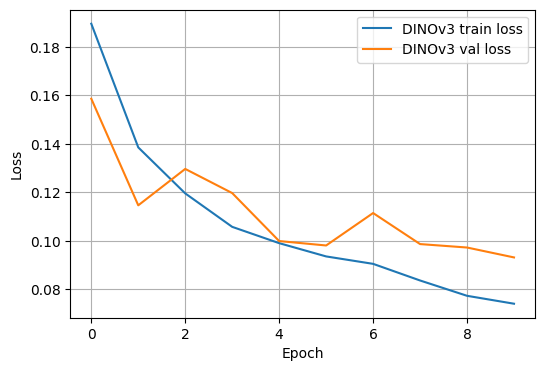

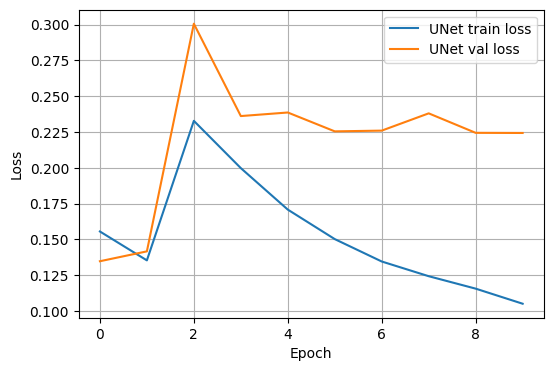

In [14]:
import matplotlib.pyplot as plt

# --- DINOv3 curves ---
d_train = history["dinov3"]["train_loss"]
d_val   = [m["loss"] for m in history["dinov3"]["val_metrics"]]

plt.figure(figsize=(6,4))
plt.plot(d_train, label="DINOv3 train loss")
plt.plot(d_val,   label="DINOv3 val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- UNet curves ---
u_train = history["unet"]["train_loss"]
u_val   = [m["loss"] for m in history["unet"]["val_metrics"]]

plt.figure(figsize=(6,4))
plt.plot(u_train, label="UNet train loss")
plt.plot(u_val,   label="UNet val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
d_last = history["dinov3"]["val_metrics"][-1]
u_last = history["unet"]["val_metrics"][-1]

print("DINOv3 val:", d_last)
print("UNet   val:", u_last)

DINOv3 val: {'abs_rel': 0.13912053896949209, 'rmse': 0.08020458087838929, 'delta1': 0.8075901557659281, 'delta2': 0.9729984941153691, 'delta3': 0.9968146620125606, 'loss': 0.0931701294307051}
UNet   val: {'abs_rel': 0.3180377424277108, 'rmse': 0.14779249604406028, 'delta1': 0.5421228474584119, 'delta2': 0.8112521204455145, 'delta3': 0.9341641656283675, 'loss': 0.2243191065973249}


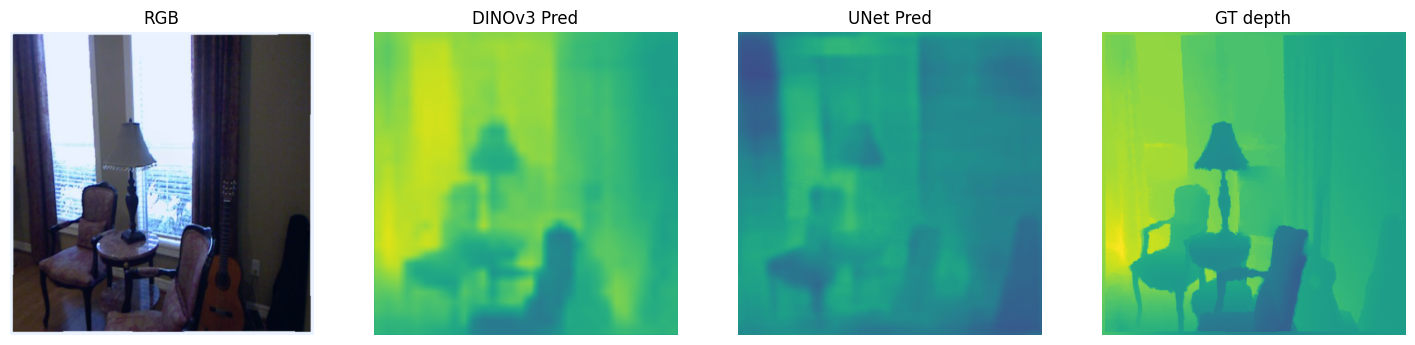

DINO pred min/max/mean: 0.40958655 0.95061326 0.72117406
UNet pred min/max/mean: 0.24026251 0.70963824 0.49685296
GT   min/max/mean: 0.3079881 0.99803156 0.65878075
------------------------------------------------------------


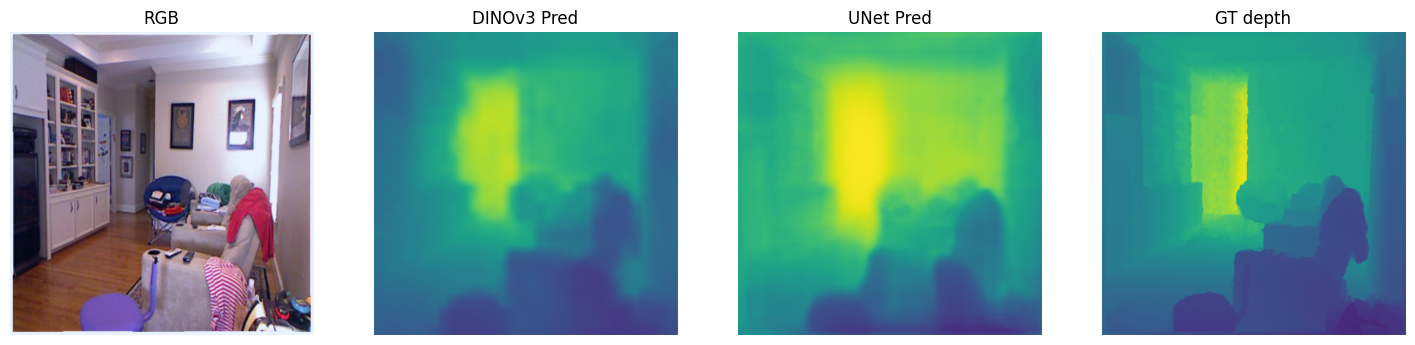

DINO pred min/max/mean: 0.16207588 0.90280676 0.47159755
UNet pred min/max/mean: 0.12621465 0.9935992 0.6288603
GT   min/max/mean: 0.11471733 1.0 0.4600965
------------------------------------------------------------


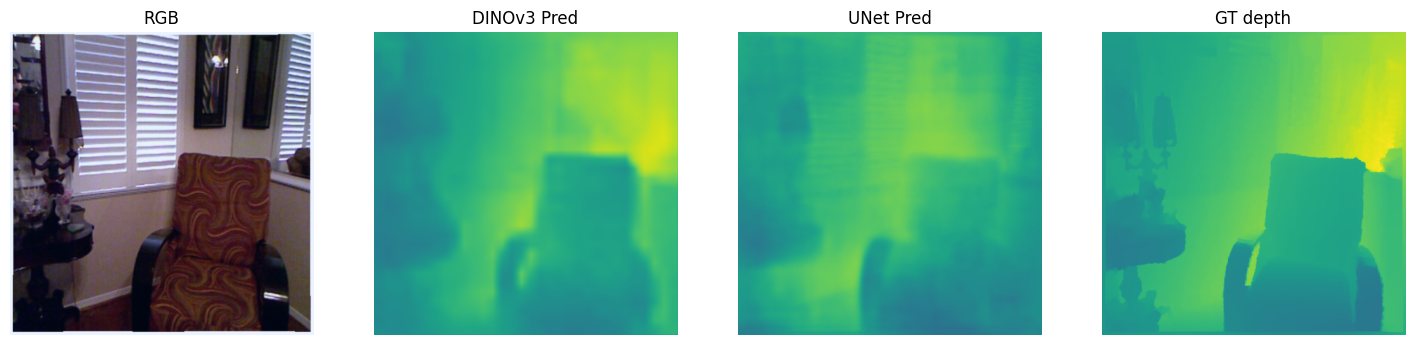

DINO pred min/max/mean: 0.40543252 0.9448461 0.6311934
UNet pred min/max/mean: 0.37236938 0.8197213 0.6200583
GT   min/max/mean: 0.39533073 1.0 0.6480245
------------------------------------------------------------


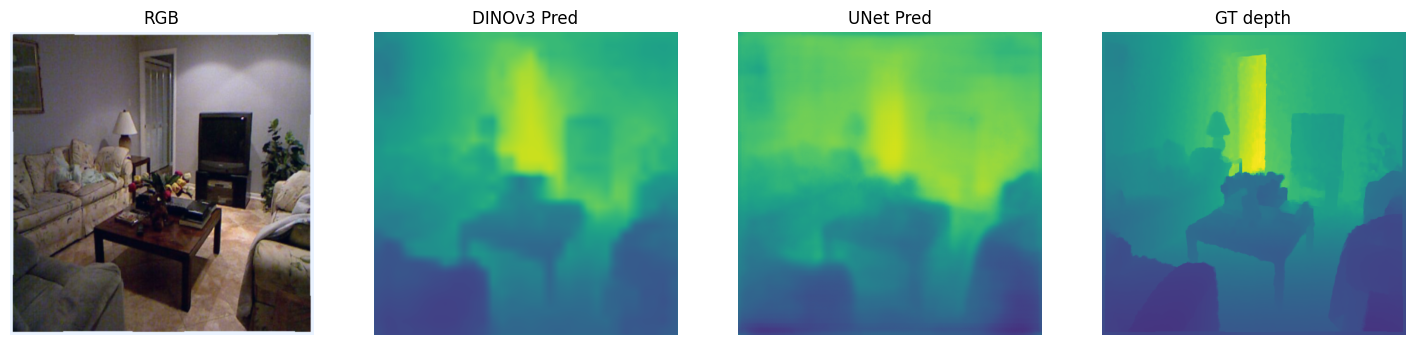

DINO pred min/max/mean: 0.19401495 0.9214605 0.5273721
UNet pred min/max/mean: 0.13804646 0.9337078 0.58860403
GT   min/max/mean: 0.15379567 1.0 0.46579823
------------------------------------------------------------


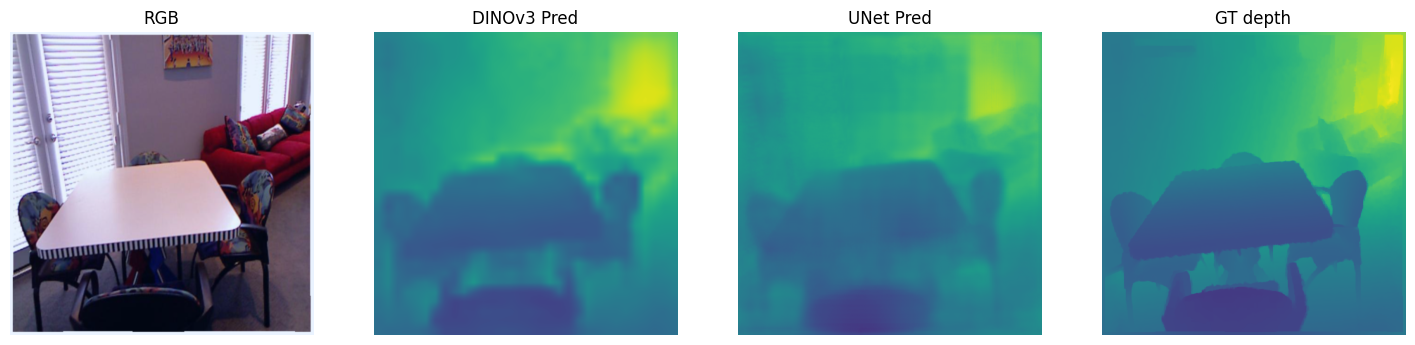

DINO pred min/max/mean: 0.19999206 0.94984454 0.49278584
UNet pred min/max/mean: 0.15704417 0.88480675 0.496986
GT   min/max/mean: 0.16839856 1.0 0.466973
------------------------------------------------------------


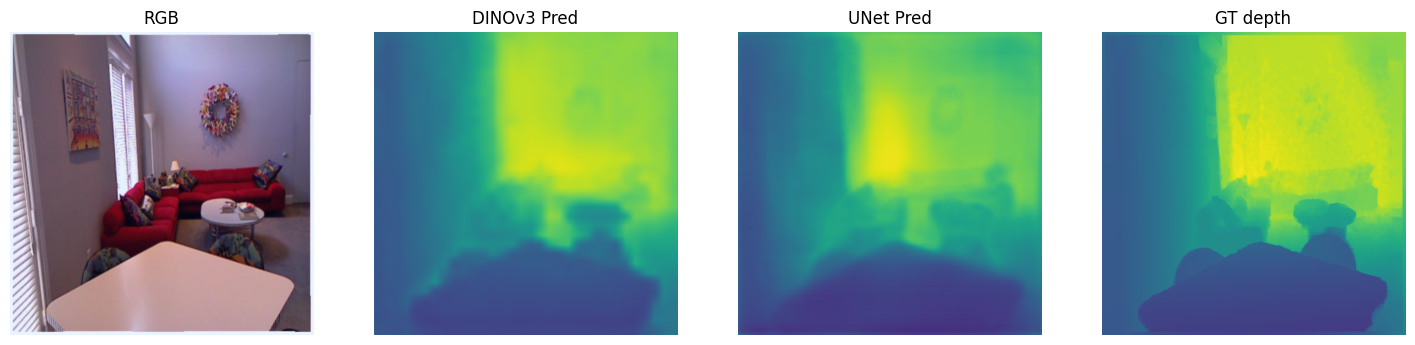

DINO pred min/max/mean: 0.1953058 0.95207036 0.54423153
UNet pred min/max/mean: 0.13262895 0.9724572 0.51949924
GT   min/max/mean: 0.17586023 1.0 0.5571875
------------------------------------------------------------


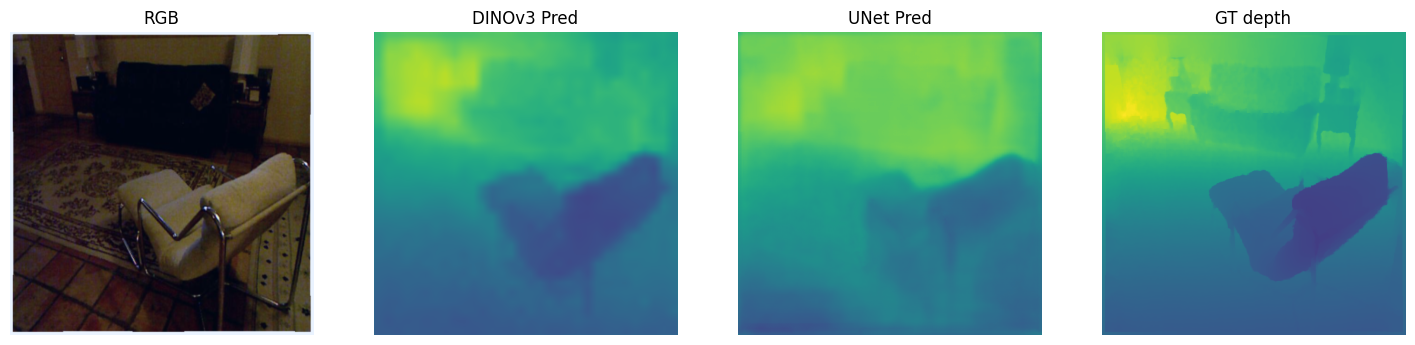

DINO pred min/max/mean: 0.21322638 0.8935877 0.49445888
UNet pred min/max/mean: 0.23320739 0.873906 0.58227617
GT   min/max/mean: 0.17935455 1.0 0.50513554
------------------------------------------------------------


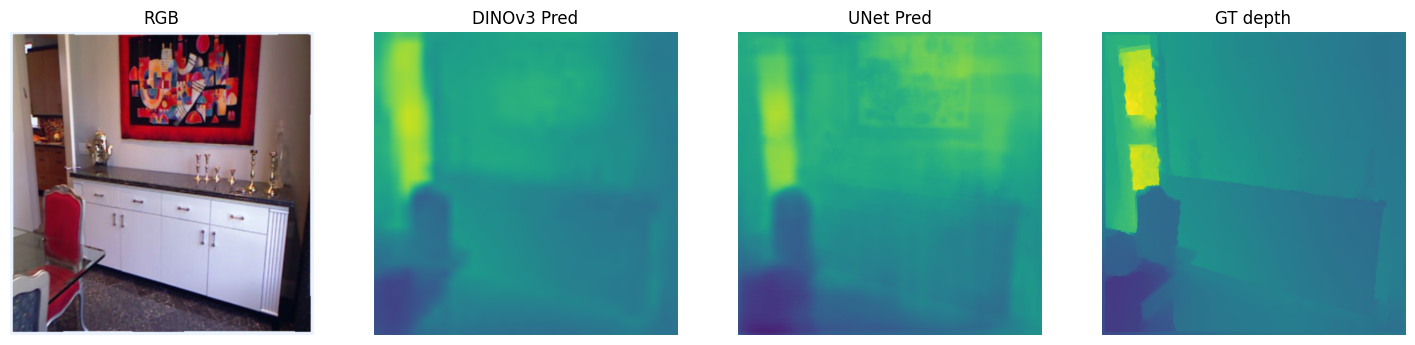

DINO pred min/max/mean: 0.2023431 0.91355455 0.50067306
UNet pred min/max/mean: 0.09379373 0.8800759 0.5436495
GT   min/max/mean: 0.1638819 1.0 0.45882714
------------------------------------------------------------


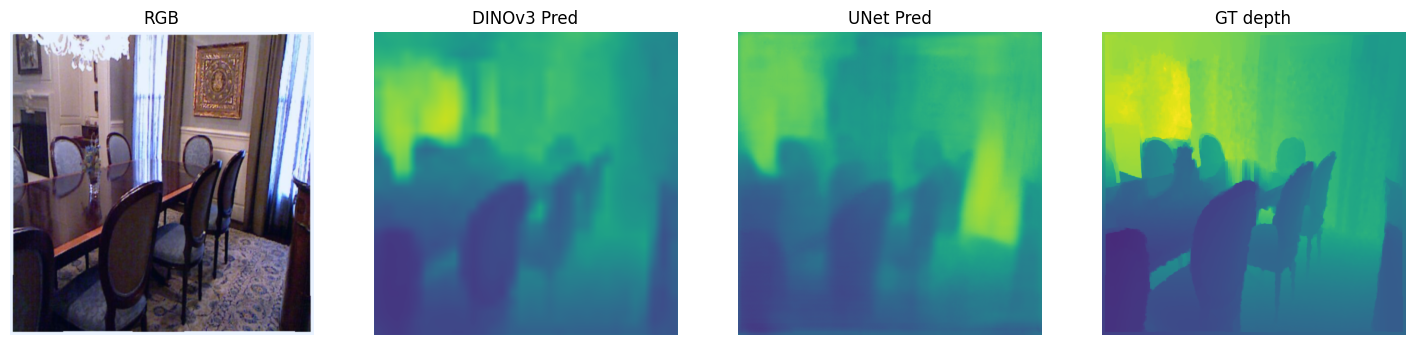

DINO pred min/max/mean: 0.15802592 0.91439456 0.46425578
UNet pred min/max/mean: 0.16961569 0.8672002 0.51138306
GT   min/max/mean: 0.122209504 1.0 0.51978487
------------------------------------------------------------


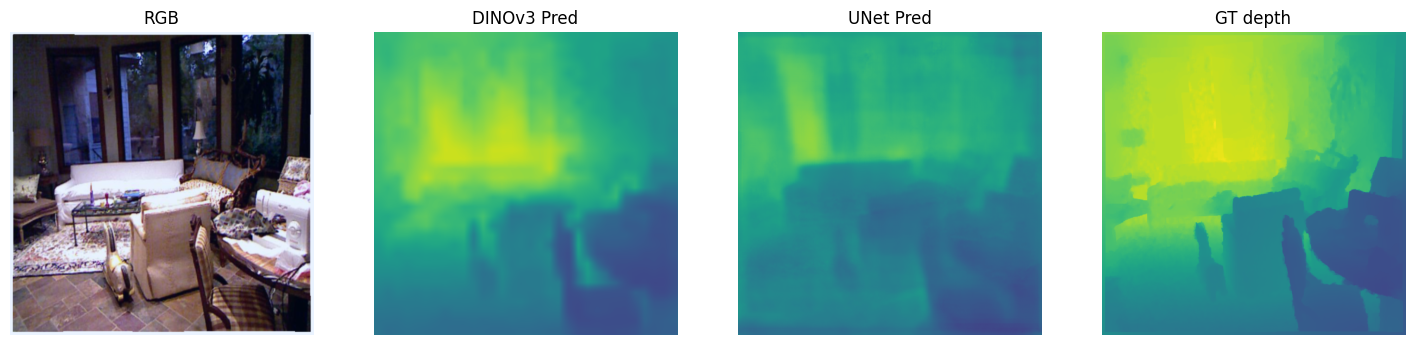

DINO pred min/max/mean: 0.21840893 0.9224337 0.57057464
UNet pred min/max/mean: 0.20426293 0.83728606 0.5101803
GT   min/max/mean: 0.22052339 1.0 0.6321992
------------------------------------------------------------


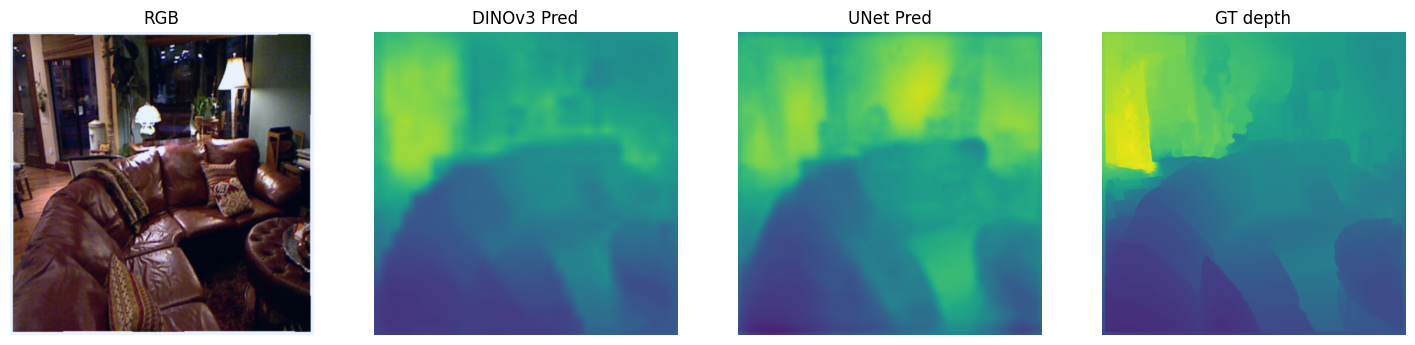

DINO pred min/max/mean: 0.14957339 0.8632417 0.46141294
UNet pred min/max/mean: 0.09358433 0.92177707 0.5511811
GT   min/max/mean: 0.12771802 1.0 0.46403697
------------------------------------------------------------


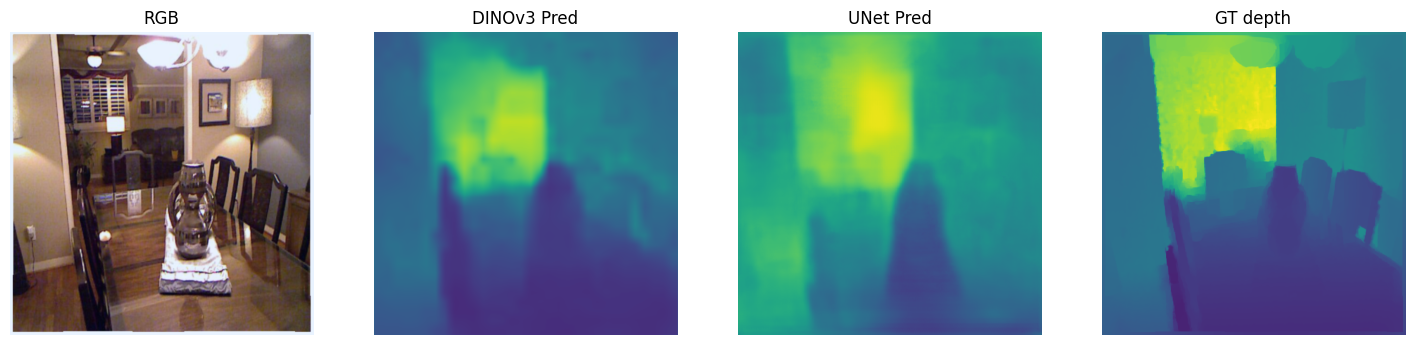

DINO pred min/max/mean: 0.12335503 0.90296674 0.37076467
UNet pred min/max/mean: 0.1841662 0.9689239 0.5437882
GT   min/max/mean: 0.096528575 1.0 0.403327
------------------------------------------------------------


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Setup loader ---
device = "cuda" if torch.cuda.is_available() else "cpu"

val_ds = NYUDepthV2Dataset("data/nyu_depth_v2", split="val", img_size=512)
val_loader = DataLoader(
    val_ds,
    batch_size=4,        # how many images per batch
    shuffle=True,        # random samples each run
    num_workers=1,
    pin_memory=device.startswith("cuda"),
)

dinov3_model.eval()
unet_model.eval()

# --- Visualize N images total ---
N_IMAGES = 12   # total images to show
shown = 0

with torch.no_grad():
    for rgb, depth_gt in val_loader:
        rgb = rgb.to(device)
        depth_gt = depth_gt.to(device)

        # forward
        raw_d = dinov3_model(rgb)               # [B,1,H,W] logits
        pred_d = torch.sigmoid(raw_d)           # [B,1,H,W] in [0,1]

        raw_u = unet_model(rgb)
        pred_u = torch.sigmoid(raw_u)

        # move to cpu numpy
        rgb_np  = rgb.cpu().numpy()             # [B,3,H,W]
        gt_np   = depth_gt.cpu().numpy()        # [B,1,H,W]
        dino_np = pred_d.cpu().numpy()          # [B,1,H,W]
        unet_np = pred_u.cpu().numpy()          # [B,1,H,W]

        B = rgb_np.shape[0]
        for b in range(B):
            rgb_vis = np.transpose(rgb_np[b], (1,2,0))
            rgb_vis = (rgb_vis - rgb_vis.min()) / (rgb_vis.max() - rgb_vis.min() + 1e-8)

            gt   = gt_np[b,0]
            dino = dino_np[b,0]
            unet = unet_np[b,0]

            plt.figure(figsize=(18,4))
            plt.subplot(1,4,1); plt.imshow(rgb_vis); plt.title("RGB"); plt.axis("off")
            plt.subplot(1,4,2); plt.imshow(dino, vmin=0, vmax=1, cmap="viridis"); plt.title("DINOv3 Pred"); plt.axis("off")
            plt.subplot(1,4,3); plt.imshow(unet, vmin=0, vmax=1, cmap="viridis"); plt.title("UNet Pred"); plt.axis("off")
            plt.subplot(1,4,4); plt.imshow(gt,   vmin=0, vmax=1, cmap="viridis"); plt.title("GT depth"); plt.axis("off")
            plt.show()

            print("DINO pred min/max/mean:", dino.min(), dino.max(), dino.mean())
            print("UNet pred min/max/mean:", unet.min(), unet.max(), unet.mean())
            print("GT   min/max/mean:", gt.min(), gt.max(), gt.mean())
            print("-" * 60)

            shown += 1
            if shown >= N_IMAGES:
                break

        if shown >= N_IMAGES:
            break


In [17]:
import numpy as np

dinov3_model.eval()
metrics = []
with torch.no_grad():
    for rgb, depth in val_loader:
        rgb, depth = rgb.to(device), depth.to(device)
        pred = dinov3_model(rgb)
        metrics.append(compute_depth_metrics(pred, depth))

print("Mean δ1:", np.mean([m["delta1"] for m in metrics]))
print("Mean δ2:", np.mean([m["delta2"] for m in metrics]))
print("Mean δ3:", np.mean([m["delta3"] for m in metrics]))


Mean δ1: 0.09790152719576065
Mean δ2: 0.19759903215382196
Mean δ3: 0.29320012706599824


x shape: (1, 3, 512, 512) gt shape: (1, 1, 512, 512)
cos(DINO, GT)   : 0.9649492502212524
cos(UNet, GT)   : 0.9474396705627441
cos(DINO, UNet) : 0.9736161828041077


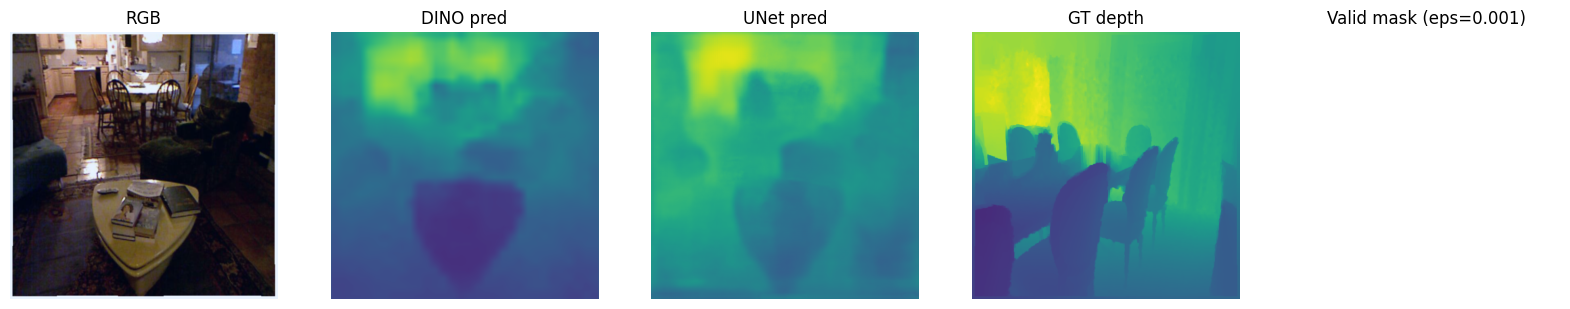

DINO pred min/max/mean: 0.13754279911518097 0.8619629740715027 0.38724395632743835
UNet pred min/max/mean: 0.3044591248035431 0.9604371786117554 0.5501253008842468
GT   min/max/mean: 0.12220950424671173 1.0 0.5197848677635193
mask valid fraction: 1.0


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

eps = 1e-3

dinov3_model.eval()
unet_model.eval()

# --------- helpers to ensure correct shapes ----------
def ensure_bchw_rgb(rgb, sample_idx=0):
    """
    Accepts:
      - rgb: [3,H,W] or [B,3,H,W]
    Returns:
      - x:  [1,3,H,W]
      - rgb_single: [3,H,W] (for visualization)
    """
    if rgb.ndim == 3:
        rgb_single = rgb
        x = rgb.unsqueeze(0)
    elif rgb.ndim == 4:
        rgb_single = rgb[sample_idx]
        x = rgb[sample_idx:sample_idx+1]
    else:
        raise ValueError(f"rgb must be 3D or 4D, got shape {tuple(rgb.shape)}")
    return x, rgb_single

def ensure_b1hw_depth(depth, sample_idx=0):
    """
    Accepts:
      - depth: [1,H,W] or [B,1,H,W]
    Returns:
      - gt: [1,1,H,W]
      - depth_single: [1,H,W] (for visualization)
    """
    if depth.ndim == 3:
        depth_single = depth
        gt = depth.unsqueeze(0)
    elif depth.ndim == 4:
        depth_single = depth[sample_idx]
        gt = depth[sample_idx:sample_idx+1]
    else:
        raise ValueError(f"depth must be 3D or 4D, got shape {tuple(depth.shape)}")
    return gt, depth_single

# --------- pick which sample to visualize if batched ----------
sample_idx = 0

# IMPORTANT: this uses your existing variables `rgb` and `depth_gt`
x,  rgb_single   = ensure_bchw_rgb(rgb, sample_idx=sample_idx)
gt, depth_single = ensure_b1hw_depth(depth_gt, sample_idx=sample_idx)

x  = x.to(device)   # [1,3,H,W]
gt = gt.to(device)  # [1,1,H,W]

print("x shape:", tuple(x.shape), "gt shape:", tuple(gt.shape))  # should be (1,3,H,W) and (1,1,H,W)

# --------- forward ----------
with torch.no_grad():
    raw_d = dinov3_model(x)           # [1,1,H,W] logits
    raw_u = unet_model(x)             # [1,1,H,W] logits
    dino  = torch.sigmoid(raw_d)      # [1,1,H,W] in [0,1]
    unet  = torch.sigmoid(raw_u)      # [1,1,H,W] in [0,1]

# --------- valid mask ----------
mask = (gt > eps) & torch.isfinite(gt) & torch.isfinite(dino) & torch.isfinite(unet)  # [1,1,H,W]

# --------- cosine similarity over valid pixels ----------
gt_v   = gt[mask]
dino_v = dino[mask]
unet_v = unet[mask]

if gt_v.numel() < 10:
    print("Too few valid pixels after masking (num_valid =", gt_v.numel(), "). Try lower eps or check GT range.")
else:
    cos_dino_gt   = F.cosine_similarity(dino_v.flatten(), gt_v.flatten(), dim=0).item()
    cos_unet_gt   = F.cosine_similarity(unet_v.flatten(), gt_v.flatten(), dim=0).item()
    cos_dino_unet = F.cosine_similarity(dino_v.flatten(), unet_v.flatten(), dim=0).item()

    print("cos(DINO, GT)   :", cos_dino_gt)
    print("cos(UNet, GT)   :", cos_unet_gt)
    print("cos(DINO, UNet) :", cos_dino_unet)

# --------- visuals ----------
# rgb_single is [3,H,W]
rgb_vis = rgb_single.permute(1,2,0).detach().cpu().numpy()
rgb_vis = (rgb_vis - rgb_vis.min()) / (rgb_vis.max() - rgb_vis.min() + 1e-8)

dino_np = dino[0,0].detach().cpu().numpy()
unet_np = unet[0,0].detach().cpu().numpy()
gt_np   = depth_single[0].detach().cpu().numpy()  # depth_single is [1,H,W]
mask_np = mask[0,0].detach().cpu().numpy().astype(np.float32)

plt.figure(figsize=(20,4))
plt.subplot(1,5,1); plt.imshow(rgb_vis); plt.title("RGB"); plt.axis("off")
plt.subplot(1,5,2); plt.imshow(dino_np, vmin=0, vmax=1, cmap="viridis"); plt.title("DINO pred"); plt.axis("off")
plt.subplot(1,5,3); plt.imshow(unet_np, vmin=0, vmax=1, cmap="viridis"); plt.title("UNet pred"); plt.axis("off")
plt.subplot(1,5,4); plt.imshow(gt_np,   vmin=0, vmax=1, cmap="viridis"); plt.title("GT depth"); plt.axis("off")
plt.subplot(1,5,5); plt.imshow(mask_np, vmin=0, vmax=1, cmap="gray");   plt.title(f"Valid mask (eps={eps})"); plt.axis("off")
plt.show()

print("DINO pred min/max/mean:", float(dino_np.min()), float(dino_np.max()), float(dino_np.mean()))
print("UNet pred min/max/mean:", float(unet_np.min()), float(unet_np.max()), float(unet_np.mean()))
print("GT   min/max/mean:", float(gt_np.min()), float(gt_np.max()), float(gt_np.mean()))
print("mask valid fraction:", float(mask_np.mean()))


In [19]:
import numpy as np
import torch
import torch.nn.functional as F

eps = 1e-3
dinov3_model.eval(); unet_model.eval()

rgb, gt = next(iter(val_loader))          # rgb: (B,3,H,W), gt: (B,1,H,W)
rgb, gt = rgb.to(device), gt.to(device)

with torch.no_grad():
    dino = torch.sigmoid(dinov3_model(rgb))   # (B,1,H,W)
    unet = torch.sigmoid(unet_model(rgb))     # (B,1,H,W)

mask = (gt > eps) & torch.isfinite(gt) & torch.isfinite(dino) & torch.isfinite(unet)  # (B,1,H,W)

cos_dino_gt, cos_unet_gt, cos_dino_unet = [], [], []
B = rgb.shape[0]

for b in range(B):
    m = mask[b,0]  # (H,W)
    if m.sum() < 10:
        continue
    gt_v   = gt[b,0][m].flatten()
    dino_v = dino[b,0][m].flatten()
    unet_v = unet[b,0][m].flatten()

    cos_dino_gt.append(F.cosine_similarity(dino_v, gt_v, dim=0).item())
    cos_unet_gt.append(F.cosine_similarity(unet_v, gt_v, dim=0).item())
    cos_dino_unet.append(F.cosine_similarity(dino_v, unet_v, dim=0).item())

print("Mean cos(DINO, GT):", float(np.mean(cos_dino_gt)))
print("Mean cos(UNet, GT):", float(np.mean(cos_unet_gt)))
print("Mean cos(DINO, UNet):", float(np.mean(cos_dino_unet)))


Mean cos(DINO, GT): 0.9940396696329117
Mean cos(UNet, GT): 0.9758861213922501
Mean cos(DINO, UNet): 0.9749554395675659


In [20]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- ImageNet unnormalize (used by NYU loader in your notebook) ----
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def unnormalize_img(x: torch.Tensor) -> torch.Tensor:
    # x: (3,H,W) normalized -> (3,H,W) in [0,1]
    return (x * IMAGENET_STD.to(x.device) + IMAGENET_MEAN.to(x.device)).clamp(0, 1)

# ---- Patch-norm map from DINOv3 ViT tokens via vit.norm hook ----
@torch.no_grad()
def patch_norm_map_from_vit_norm(vit, x, patch_size=16):
    """
    vit: dinov3_model.encoder.encoder (DinoVisionTransformer)
    x: (B,3,H,W) normalized input
    returns: (B, Gh, Gw) patch-norm map (patch tokens only; drops CLS/storage tokens)
    """
    vit.eval()
    cache = {}

    def _hook(_m, _inp, out):
        # out may be tensor or wrapped
        if torch.is_tensor(out):
            cache["tokens"] = out
        elif isinstance(out, (list, tuple)):
            for z in out:
                if torch.is_tensor(z):
                    cache["tokens"] = z
                    break
        elif isinstance(out, dict):
            for k, v in out.items():
                if torch.is_tensor(v) and v.ndim == 3:
                    cache["tokens"] = v
                    break

    h = vit.norm.register_forward_hook(_hook)
    _ = vit(x)   # final output can be (B,768); tokens are captured by hook
    h.remove()

    tokens = cache.get("tokens", None)
    if tokens is None:
        raise RuntimeError("Could not capture token sequence from vit.norm hook.")

    if tokens.ndim != 3:
        raise ValueError(f"Expected (B,T,D) tokens, got {tuple(tokens.shape)}")

    B, T, D = tokens.shape
    H, W = x.shape[-2], x.shape[-1]

    Gh = H // patch_size
    Gw = W // patch_size
    N = Gh * Gw

    extra = T - N
    if extra < 0:
        raise RuntimeError(f"T={T} < N={N}. Check patch_size or input size.")

    patch_tokens = tokens[:, extra:extra + N, :]   # drop CLS + storage tokens
    norms = patch_tokens.norm(dim=-1)              # (B, N)
    return norms.view(B, Gh, Gw)

def show_patch_norm_overlay_nicer(rgb_batch: torch.Tensor,
                                 patch_map: torch.Tensor,
                                 idx: int = 0,
                                 title: str = "Patch-norm",
                                 alpha: float = 0.25,
                                 add_colorbar: bool = True):
    """
    rgb_batch: (B,3,H,W) normalized
    patch_map: (B,Gh,Gw) patch norms
    """
    # --- RGB ---
    rgb = unnormalize_img(rgb_batch[idx].detach().cpu())      # (3,H,W) in [0,1]
    rgb_np = rgb.permute(1, 2, 0).numpy()                     # (H,W,3)

    # --- Heatmap (normalize + smooth upsample) ---
    pm = patch_map[idx].detach()                               # (Gh,Gw)
    pm = pm.unsqueeze(0).unsqueeze(0)                          # (1,1,Gh,Gw)

    H, W = rgb_batch.shape[-2], rgb_batch.shape[-1]
    pm_up = F.interpolate(pm, size=(H, W), mode="bilinear", align_corners=False)[0,0]  # (H,W)
    pm_up = pm_up.cpu().numpy()

    # robust normalization (2nd–98th percentile)
    lo, hi = np.percentile(pm_up, [2, 98])
    pm_norm = np.clip((pm_up - lo) / (hi - lo + 1e-8), 0, 1)

    # --- Plot ---
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.title("RGB")
    plt.imshow(rgb_np)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title(title)
    im = plt.imshow(pm_norm)
    plt.axis("off")
    if add_colorbar:
        plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(rgb_np)
    plt.imshow(pm_norm, alpha=alpha)  # smoother + better contrast
    plt.axis("off")

    plt.show()


In [21]:
import torch

@torch.no_grad()
def delta_per_sample(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-3):
    """
    pred, target: (B,1,H,W) in same scale (your NYU loader gives depth in [0,1])
    returns dict of tensors (B,) for delta1/delta2/delta3
    """
    pred = pred.clamp_min(eps)
    target = target.clamp_min(eps)

    valid = target > eps  # (B,1,H,W)

    ratio = torch.maximum(pred / target, target / pred)  # (B,1,H,W)
    # mean over valid pixels, per image
    def _mean(mask):
        m = (mask & valid).float()
        return m.sum(dim=(1,2,3)) / (valid.float().sum(dim=(1,2,3)) + 1e-8)

    d1 = _mean(ratio < 1.25)
    d2 = _mean(ratio < 1.25**2)
    d3 = _mean(ratio < 1.25**3)
    return {"delta1": d1, "delta2": d2, "delta3": d3}


[sample 0] δ1=0.955  δ2=0.996  δ3=1.000


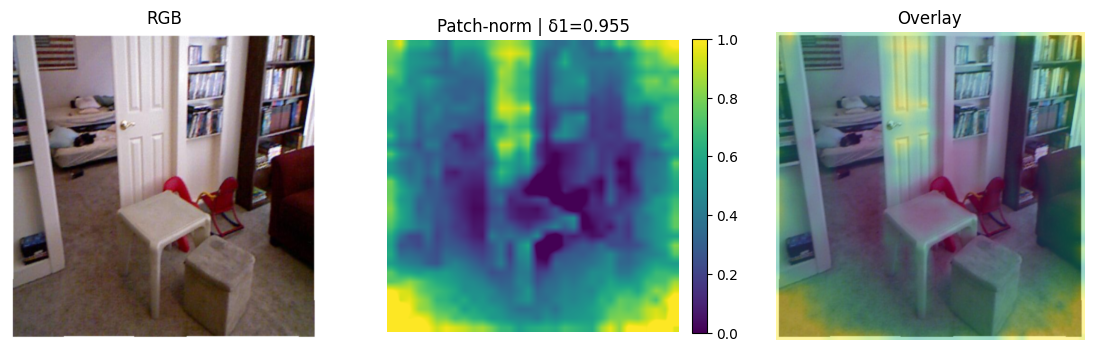

[sample 1] δ1=0.995  δ2=1.000  δ3=1.000


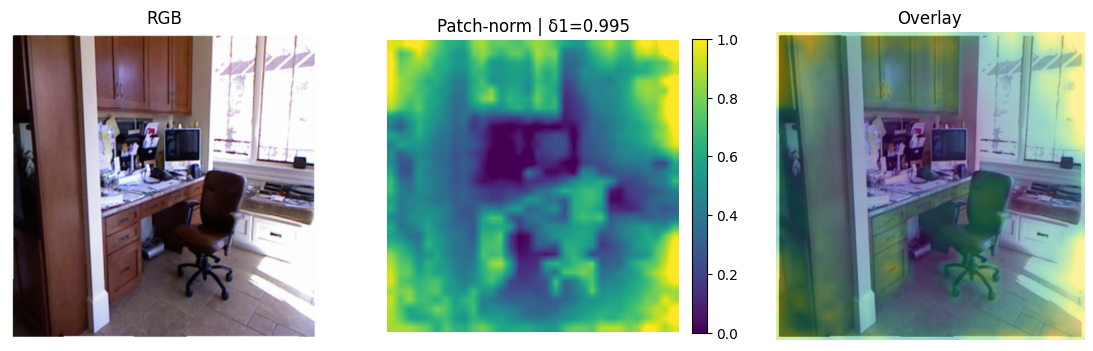

[sample 2] δ1=0.931  δ2=1.000  δ3=1.000


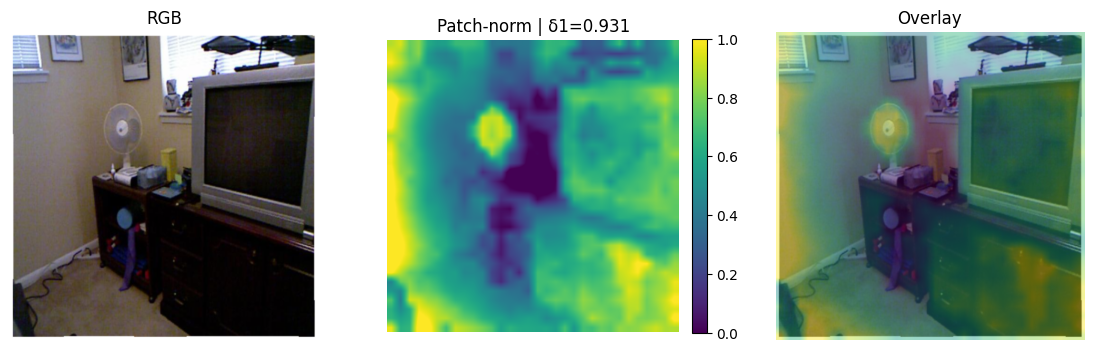

[sample 3] δ1=0.991  δ2=0.998  δ3=1.000


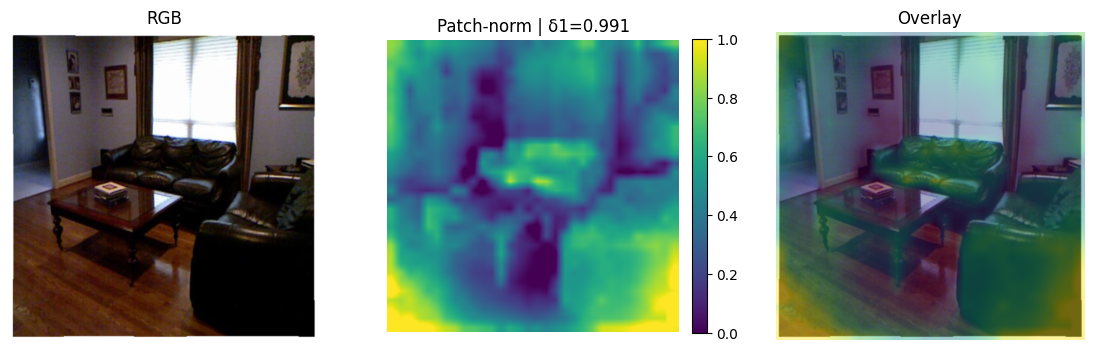

In [22]:
vit = dinov3_model.encoder.encoder

rgb, depth = next(iter(val_loader))
rgb, depth = rgb.to(device), depth.to(device)          # depth: (B,1,H,W)

# patch norm
patch_map = patch_norm_map_from_vit_norm(vit, rgb, patch_size=16)

# depth prediction
with torch.no_grad():
    raw = dinov3_model(rgb)                             # (B,1,H,W) logits
    pred = torch.sigmoid(raw).clamp_min(1e-3)           # (B,1,H,W)

deltas = delta_per_sample(pred, depth, eps=1e-3)        # each is (B,)

K = min(6, rgb.shape[0])
for i in range(K):
    print(f"[sample {i}] δ1={float(deltas['delta1'][i]):.3f}  "
          f"δ2={float(deltas['delta2'][i]):.3f}  δ3={float(deltas['delta3'][i]):.3f}")
    show_patch_norm_overlay_nicer(
        rgb, patch_map, idx=i,
        title=f"Patch-norm | δ1={float(deltas['delta1'][i]):.3f}",
        alpha=0.45, add_colorbar=True
    )
